In [3]:
import torch
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
       
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 3050 6GB Laptop GPU


C:\Users\nandh\.astroNN\datasets\Galaxy10_DECals.h5 was found!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input da

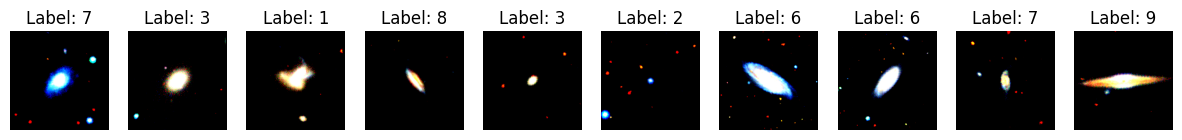

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from astroNN.datasets import galaxy10
from torchvision import transforms

# Function to visualize dataset samples
def show_sample_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        image, label = dataset[i]
        image = image.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to (H, W, C)
        
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    
    plt.show()

# Show random samples from training dataset

class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
images, labels = galaxy10.load_data()
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = Galaxy10Dataset(train_images, train_labels, transform=transform)

show_sample_images(train_dataset)


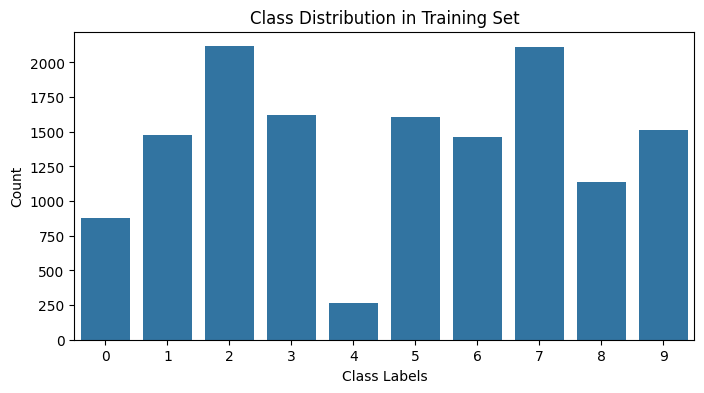

In [7]:
import seaborn as sns
import numpy as np
# Count occurrences of each label
unique, counts = np.unique(train_labels, return_counts=True)
len(unique)
# Plot class distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=unique, y=counts)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.show()

In [10]:
counts

array([ 877, 1480, 2116, 1619,  263, 1607, 1464, 2112, 1140, 1510])

In [15]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import h5py
from n import Galaxy10CNN, device  # Import model & device from n.py

# Define Class Labels
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", 
               "Class 5", "Class 6", "Class 7", "Class 8", "Class 9"]

# Define Dataset Class
class Galaxy10Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.transform = transform

        with h5py.File(self.h5_path, "r") as f:
            self.images = np.array(f["images"])  # Shape: (21785, 128, 128, 3)
            self.labels = np.array(f["ans"])     # Shape: (21785,)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (128, 128, 3)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define Transformations (Copied from n.py)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset
data_path = "path/to/Galaxy10_DECals.h5"  # Update with the correct path
full_dataset = Galaxy10Dataset(data_path, transform=transform)

# Split Dataset (Ensure same as training)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create Validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load Model
model = Galaxy10CNN(num_classes=10).to(device)
model.load_state_dict(torch.load("galaxy10_final.pth", map_location=device))
model.eval()

# Initialize lists for predictions & labels
all_preds = []
all_labels = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Identify Misclassified Classes
misclassified_counts = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
for idx, count in enumerate(misclassified_counts):
    print(f"Class {class_names[idx]} → Misclassified {count} times")

print("🔍 Use these results to adjust class weights or improve data balance!")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'path/to/Galaxy10_DECals.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
import cv2
from prepareTheData import *
ok=(get_image_path("115400"))
ok


WindowsPath('C:/Users/nandh/Downloads/images_gz2/images/115400.jpg')

In [6]:
print(f"Image path: {ok}")  # Should print the correct path
print(ok.exists())  # Should return True if the image exists

Image path: C:\Users\nandh\Downloads\images_gz2\images\115400.jpg
True


In [ ]:
ff=cv2.imread(ok)
cv2.imshow("ef",ff)

In [ ]:
from PIL import Image
image = Image.open(str(ok))
image.show() 

: 

In [12]:
import pandas as pd

# Load the CSV files
df_labels = pd.read_csv(r"C:\Users\nandh\Downloads\GalaxyZoo1_DR_table2.csv")
df_mapping = pd.read_csv(r"C:\Users\nandh\Downloads\gz2_filename_mapping.csv")

# Merge on the OBJID
df = pd.merge(df_mapping, df_labels, left_on="objid", right_on="OBJID")

# Count the different galaxy types
spiral_count = (df["SPIRAL"] == 1).sum()
elliptical_count = (df["ELLIPTICAL"] == 1).sum()
irregular_count = ((df["SPIRAL"] == 0) & (df["ELLIPTICAL"] == 0)).sum()  # Remaining are irregular


# Print the counts
print(f"Spiral: {spiral_count}")
print(f"Elliptical: {elliptical_count}")
print(f"Irregular: {irregular_count}")

Spiral: 83958
Elliptical: 34481
Irregular: 130456


In [14]:
from prepareTheData import *

In [15]:
print(df.head())  # Ensure 'image_path' exists and missing images are removed
print(f"Total images after filtering: {len(df)}")  # Should match count in n2.py

                 objid    sample  asset_id               OBJID           RA  \
7   587722981741756545  original        11  587722981741756545  12:15:18.25   
92  587722981748113567  original       100  587722981748113567  13:13:28.44   
93  587722981748179130  original       101  587722981748179130  13:14:06.37   
94  587722981748375756  original       102  587722981748375756  13:15:52.42   
95  587722981748375801  original       103  587722981748375801  13:16:04.92   

            DEC  NVOTE   P_EL   P_CW  P_ACW  P_EDGE   P_DK   P_MG   P_CS  \
7   -01:06:35.5     64  0.891  0.016  0.016   0.016  0.062  0.000  0.047   
92  -01:12:40.4     36  0.306  0.000  0.000   0.056  0.083  0.556  0.056   
93  -01:12:18.5     30  0.367  0.033  0.167   0.333  0.100  0.000  0.533   
94  -01:06:19.6     33  0.364  0.000  0.364   0.152  0.061  0.061  0.515   
95  -01:11:21.5     54  0.667  0.000  0.037   0.093  0.185  0.019  0.130   

    P_EL_DEBIASED  P_CS_DEBIASED  SPIRAL  ELLIPTICAL  UNCERTAIN  \
7

In [6]:
df.to_csv("filtered_dataset.csv", index=False)


In [ ]:
# df labels


13965

In [ ]:
# Count the different galaxy types
spiral_count = (df["SPIRAL"] == 1).sum()
elliptical_count = (df["ELLIPTICAL"] == 1).sum()
irregular_count = ((df["SPIRAL"] == 0) & (df["ELLIPTICAL"] == 0)).sum()  # Remaining are irregular


# Print the counts
print(f"Spiral: {spiral_count}")                    
print(f"Elliptical: {elliptical_count}")
print(f"Irregular: {irregular_count}")

Spiral: 4574
Elliptical: 2014
Irregular: 7377


In [9]:
import numpy